# Spam or Ham

In this project we will use feature engineering and logistic regression to create a classifier that will distinguish spam emails from non-spam emails.

* We will distinguish spam and non spam emails by calling the spam emails: "spam" and the non-spam emails: "ham" 

In [36]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

## Loading the data

In [2]:
import zipfile
with zipfile.ZipFile('data/spam_ham_data.zip') as item:
    item.extractall()

In [3]:
original_training_data = pd.read_csv('data/train.csv')

# Convert the emails to lower case as a first step to processing the text
original_training_data['email'] = original_training_data['email'].str.lower()

original_training_data.head()

,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


### Removing Nulls

In [4]:
print('Before imputation:')
print(original_training_data.isnull().sum())
original_training_data = original_training_data.fillna('')
print('------------')
print('After imputation:')
print(original_training_data.isnull().sum())

Before imputation:
id         0
subject    6
email      0
spam       0
dtype: int64
------------
After imputation:
id         0
subject    0
email      0
spam       0
dtype: int64


Let's take a look at the type of data we are dealing with!

In [5]:
first_ham = original_training_data.loc[original_training_data['spam'] == 0, 'email'].iloc[0]
first_spam = original_training_data.loc[original_training_data['spam'] == 1, 'email'].iloc[0]
print(first_ham)
print(first_spam)

url: http://boingboing.net/#85534171
 date: not supplied
 
 arts and letters daily, a wonderful and dense blog, has folded up its tent due 
 to the bankruptcy of its parent company. a&l daily will be auctioned off by the 
 receivers. link[1] discuss[2] (_thanks, misha!_)
 
 [1] http://www.aldaily.com/
 [2] http://www.quicktopic.com/boing/h/zlfterjnd6jf
 
 

<html>
 <head>
 </head>
 <body>
 <font size=3d"4"><b> a man endowed with a 7-8" hammer is simply<br>
  better equipped than a man with a 5-6"hammer. <br>
 <br>would you rather have<br>more than enough to get the job done or fall =
 short. it's totally up<br>to you. our methods are guaranteed to increase y=
 our size by 1-3"<br> <a href=3d"http://209.163.187.47/cgi-bin/index.php?10=
 004">come in here and see how</a>
 </body>
 </html>
 
 
 



### Training Test Split

In [6]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(original_training_data, test_size = 0.33, random_state = 42)

### Helper Function For Feature Engineering

In [7]:
def words_in_texts(words, texts):
    '''
    Args:
        words (list): words to find
        texts (Series): strings to search in
    
    Returns:
        array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    indicator_array = []
    for text in texts:
        arr = []
        for word in words:
            if word in text:
                arr.append(1)
            else:
                arr.append(0)
        indicator_array.append(arr)
    return np.array(indicator_array)



### Creating a bar chart comparing the proportion of spam and ham emails containing certain words

We need to identify features to help us distinguish between spam and ham emails. An idea can be by comparing the distribution of a single feature (words/character) in both spam and ham emails.

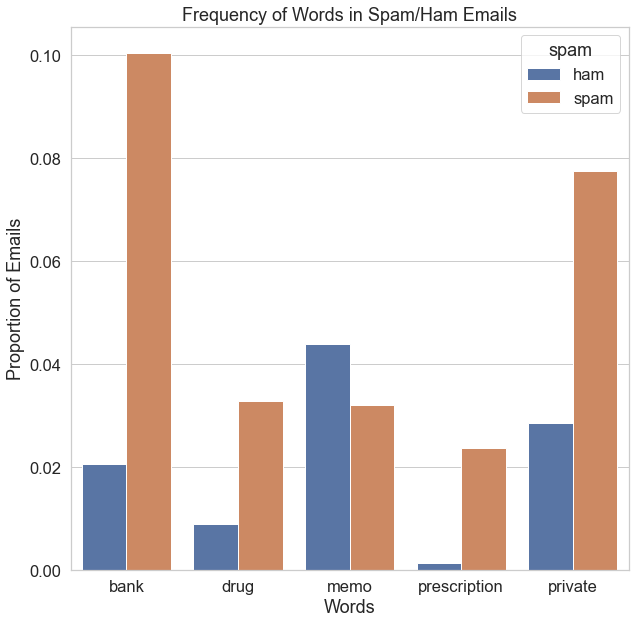

In [8]:
train = train.reset_index(drop=True) # We must do this in order to preserve the ordering of emails to labels for words_in_texts
word_set = ['drug', 'bank', 'prescription', 'memo', 'private']
my_list =  words_in_texts(word_set, train['email'])
plot_df = pd.DataFrame(my_list, columns=word_set)
#Created a dataframe with the words as columns and 0,1 as the values for the columns
plot_df['spam'] = train['spam']

plot_3_melt = plot_df.melt('spam')

plot_3_melt['spam'] = plot_3_melt['spam'].replace({0:'ham', 1:'spam'})
plot_3_melt['count'] = [1 for x in plot_3_melt['variable']]
plot_3 = plot_3_melt.groupby(['variable', 'spam']).agg(sum)


plot_3['proportion'] = plot_3['value'] / plot_3['count']
plot_3 = plot_3.reset_index()
plot_3 = plot_3.rename(columns={'variable': 'Words', 'proportion': 'Proportion of Emails'})

plt.figure(figsize=(10, 10))
plt.title('Frequency of Words in Spam/Ham Emails')
sns.barplot(data=plot_3, x='Words', y='Proportion of Emails', hue='spam');

## Classification

In [9]:
from sklearn.linear_model import LogisticRegression

some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

X_train = words_in_texts(some_words, train['email'])
Y_train = train['spam']

model = LogisticRegression()
model.fit(X_train, Y_train)

training_accuracy = model.score(X_train, Y_train)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.7580904702306455


This looks good! However we must remember that accuracy isn't the only important thing here. We must consider the model's precision and recall. 

Presumably, our classifier will be used for **filtering**, i.e. preventing messages labeled `spam` from reaching someone's inbox. There are two kinds of errors we can make:
- False positive (FP): a ham email gets flagged as spam and filtered out of the inbox.
- False negative (FN): a spam email gets mislabeled as ham and ends up in the inbox.

To be clear, we label spam emails as 1 and ham emails as 0. These definitions depend both on the true labels and the predicted labels. False positives and false negatives may be of differing importance, leading us to consider more ways of evaluating a classifier, in addition to overall accuracy:

**Precision** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FP}}$ of emails flagged as spam that are actually spam.

**Recall** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FN}}$ of spam emails that were correctly flagged as spam. 

**False-alarm rate** measures the proportion $\frac{\text{FP}}{\text{FP} + \text{TN}}$ of ham emails that were incorrectly flagged as spam. 

In [10]:
y_pred = model.predict(X_train)
tp = np.sum((y_pred == 1) & (Y_train == 1))
tn = np.sum((y_pred == 0) & (Y_train == 0))
fp = np.sum((y_pred == 1) & (Y_train == 0))
fn = np.sum((y_pred == 0) & (Y_train == 1))

first_model_precision = tp/(tp+fp)
first_model_recall = tp/(tp+fn)
first_model_far = fp/(fp+tn)

print("Out of all the emails flagged as spam, how many are actually spam: ", first_model_precision)
print("Out of all the spam emails, how many were actually flagged as spam: ", first_model_recall)
print("Out of all the ham emails, how many were incorrectly flagged as spam : ", first_model_far)

Out of all the emails flagged as spam, how many are actually spam:  0.6549019607843137
Out of all the spam emails, how many were actually flagged as spam:  0.11662011173184357
Out of all the ham emails, how many were incorrectly flagged as spam :  0.02114876231675078


# Lets improve our model

#### Lets start by using regex to find html tags

In [11]:

def find_html_tags(emails):
    '''
    Args:
        emails (series): strings to search in 
    
    Returns:
        array of 0s and 1s with shape (n, 1) where n is the
        number of emails.
    '''
    r="<\/[^>]*>"
    htmls_count = []
    for email in emails:
        amount = len(re.findall(r, email))
        if amount == 0:
            htmls_count.append(0)
        else:
            htmls_count.append(1)
    htmls_count = np.array(htmls_count)
    return htmls_count

htmls_count = find_html_tags(train['email'])
regex_parameter = pd.DataFrame({'HTML Tag Amount': htmls_count})
regex_parameter['spam'] = train['spam']

amount_html_tags_ham = sum(regex_parameter[regex_parameter['spam']==0]['HTML Tag Amount'])
amount_html_tag_spam = sum(regex_parameter[regex_parameter['spam']==1]['HTML Tag Amount'])

ham_count = len(train[train['spam']==0])
spam_count = len(train[train['spam']==1])

tags_in_ham = amount_html_tags_ham/ham_count
tags_in_spam = amount_html_tag_spam/spam_count


print("Proportions of ham emails that have html tags: ", tags_in_ham)
print("Proportions of spam emails that have html tags: ", tags_in_spam)

Proportions of ham emails that have html tags:  0.064647921172795
Proportions of spam emails that have html tags:  0.5279329608938548


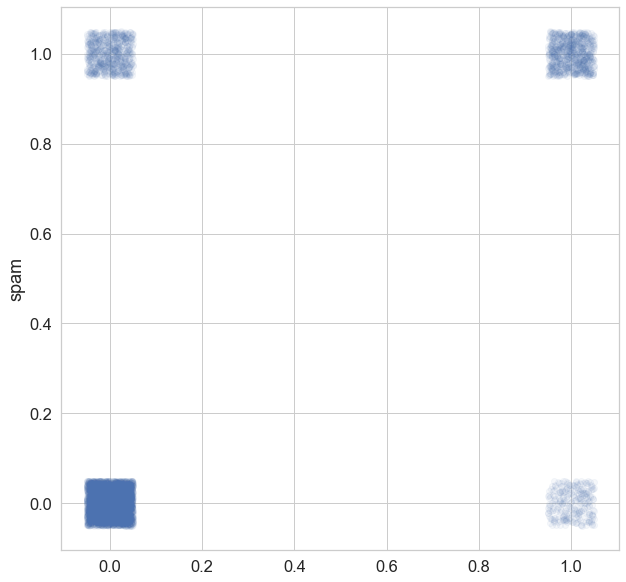

In [12]:
plt.figure(figsize=(10, 10))
sns.regplot(data=train, x=find_html_tags(train['email']), y='spam', fit_reg = False, y_jitter=0.05, x_jitter=0.05, scatter_kws = {'alpha' : 0.05});

#### Lets create the same function but instead of ones and zeros, it will give us the actual number of html tags each email contains

In [13]:
def find_html_tags_count(emails):
    '''
    Args:
        emails (series): strings to search in 
    
    Returns:
        array of 0s and 1s with shape (n, 1) where n is the
        number of emails.
    '''
    r="<\/[^>]*>"
    htmls_count = []
    for email in emails:
        amount = len(re.findall(r, email))
        htmls_count.append(amount)
    htmls_count = np.array(htmls_count)
    return htmls_count

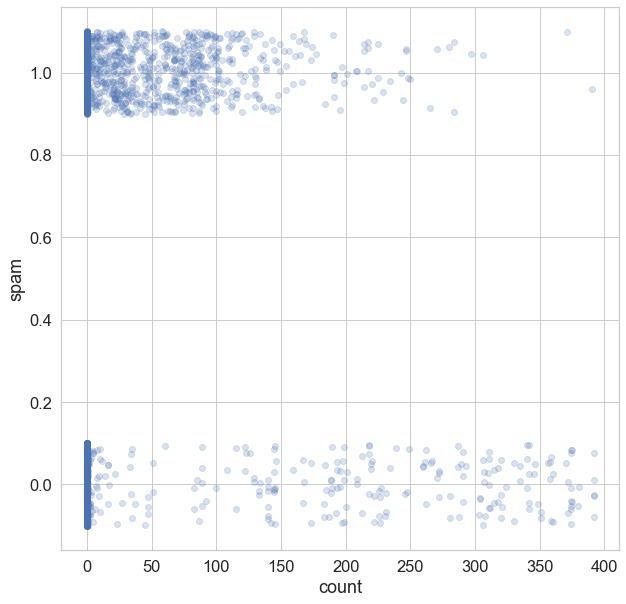

In [14]:
plt.figure(figsize=(10, 10))
num_of_htmls = pd.DataFrame({"count": find_html_tags_count(train['email']), "spam": train['spam']})
sns.regplot(data=num_of_htmls[num_of_htmls['count']<400], x='count', y='spam', fit_reg = False, y_jitter=0.1, x_jitter=0.1, scatter_kws = {'alpha' : 0.2});



#### Lets Now look if we have two exclamation marks '!!' to see if they are as good as html parameters

In [15]:
def find_exclamations(emails):
    '''
    Args:
        emails (series): strings to search in 
    
    Returns:
        array of 0s and 1s with shape (n, 1) where n is the
        number of emails.
    '''
    exclamation_count = []
    for email in emails:
        has_exclamation = '!!' in email
        if has_exclamation == 0:
            exclamation_count.append(0)
        else:
            exclamation_count.append(1)
    exclamation_count = np.array(exclamation_count)
    return exclamation_count

exclamation_count = find_exclamations(train['email'])
exclamation_parameter = pd.DataFrame({'Contains !': exclamation_count})
exclamation_parameter['spam'] = train['spam']

amount_has_exclamation_ham = sum(exclamation_parameter[exclamation_parameter['spam']==0]['Contains !'])
amount_has_exclamation_spam = sum(exclamation_parameter[exclamation_parameter['spam']==1]['Contains !'])

exclamations_in_ham = amount_has_exclamation_ham / ham_count
exclamations_in_spam = amount_has_exclamation_spam / spam_count

print("Proportions of ham emails that have exclamation marks: ", exclamations_in_ham)
print("Proportions of spam emails that have exclamation marks: ", exclamations_in_spam)

Proportions of ham emails that have exclamation marks:  0.016342225426580148
Proportions of spam emails that have exclamation marks:  0.21368715083798884


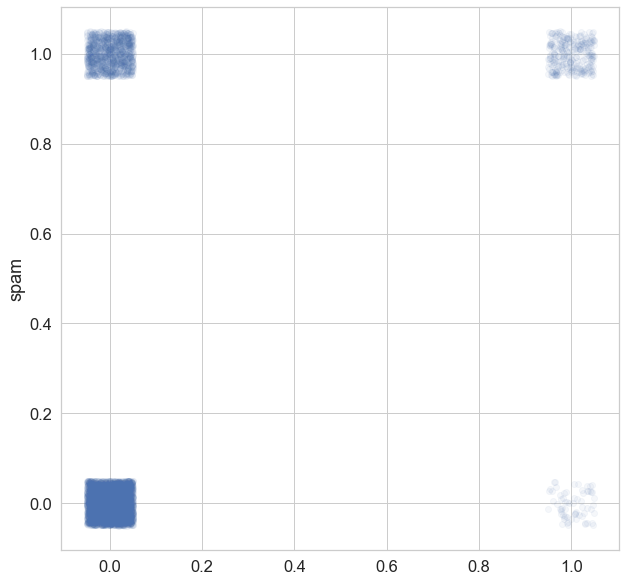

In [16]:
plt.figure(figsize=(10, 10))
sns.regplot(data=train, x=find_exclamations(train['email']), y='spam', fit_reg = False, y_jitter=0.05, x_jitter=0.05, scatter_kws = {'alpha' : 0.05});


#### Now lets take a look at whether or not an email is a reply

In [17]:
def is_reply(subjects):
    '''
    Args:
        subjects (series): strings to search in 
    
    Returns:
        array of 0s and 1s with shape (n, 1) where n is the
        number of subjects.
    '''
    reply_list = []
    for subject in subjects:
        if type(subject) == str:
            has_Re = 're:' in subject.lower()
            if has_Re == 0:
                reply_list.append(0)
            else:
                reply_list.append(1)
        else:
            reply_list.append(0)
    reply_list = np.array(reply_list)
    return reply_list

reply_list2 = is_reply(train['subject'])
reply_parameter = pd.DataFrame({'Contains Re': reply_list2})
reply_parameter['spam'] = train['spam']

amount_has_Re_ham = sum(reply_parameter[reply_parameter['spam']==0]['Contains Re'])
amount_has_Re_spam = sum(reply_parameter[reply_parameter['spam']==1]['Contains Re'])

Re_in_ham = amount_has_Re_ham / ham_count
Re_in_spam = amount_has_Re_spam / spam_count

print("Proportions of ham emails that are replies: ", Re_in_ham)
print("Proportions of spam emails that are replies: ", Re_in_spam)

Proportions of ham emails that are replies:  0.5027637587118481
Proportions of spam emails that are replies:  0.0467877094972067


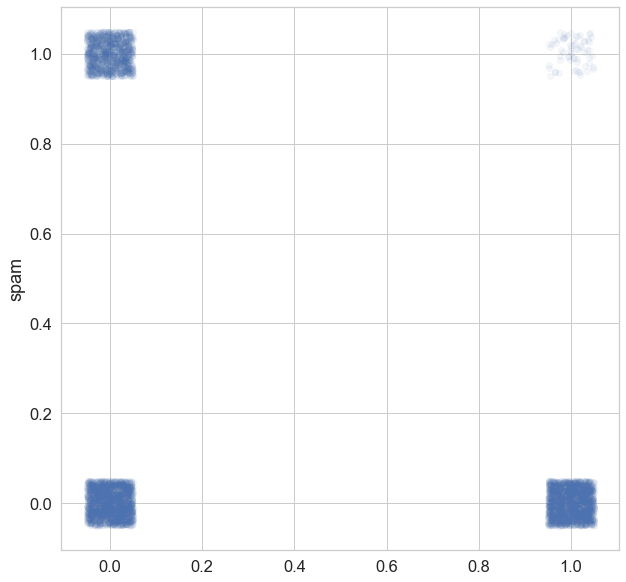

In [18]:
plt.figure(figsize=(10, 10))
sns.regplot(data=train, x=is_reply(train['subject']), y='spam', fit_reg = False, y_jitter=0.05, x_jitter=0.05, scatter_kws = {'alpha' : 0.05});

#### Lets look at less than 500 words parameter 

In [19]:
def is_less_than_500(emails):
    '''
    Args:
        emails (series): strings to search in 
    
    Returns:
        array of 0s and 1s with shape (n, 1) where n is the
        number of emails.
    '''
    less_than_500_list = []
    for email in emails:
        less_than = len(email) < 500
        if less_than == 0:
            less_than_500_list.append(0)
        else:
            less_than_500_list.append(1)
    less_than_500_list = np.array(less_than_500_list)
    return less_than_500_list

less_than_500_list = is_less_than_500(train['email'])

caps_parameter = pd.DataFrame({'<500': less_than_500_list})
caps_parameter['spam'] = train['spam']

less_than_ham = sum(caps_parameter[caps_parameter['spam']==0]['<500'])
less_than_spam = sum(caps_parameter[caps_parameter['spam']==1]['<500'])

less_prop_ham = less_than_ham / ham_count
less_prop_spam = less_than_spam / spam_count

print("Proportions of ham emails that have less than 500 words: ", less_prop_ham)
print("Proportions of spam emails that have less than 500 words: ", less_prop_spam)

Proportions of ham emails that have less than 500 words:  0.2251862533044941
Proportions of spam emails that have less than 500 words:  0.0467877094972067


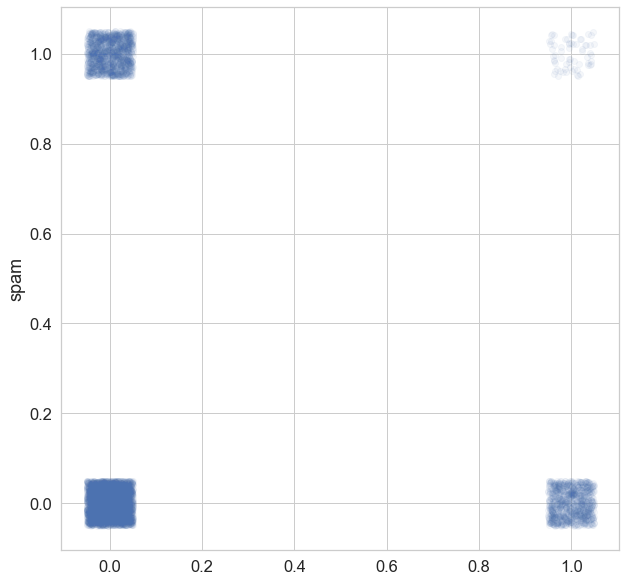

In [20]:
plt.figure(figsize=(10, 10))
sns.regplot(data=train, x=is_less_than_500(train['email']), y='spam', fit_reg = False, y_jitter=0.05, x_jitter=0.05, scatter_kws = {'alpha' : 0.05});

#### Lets look at more than 4100 words parameter 

In [21]:
def is_more_than_4100(emails):
    '''
    Args:
        emails (series): strings to search in 
    
    Returns:
        array of 0s and 1s with shape (n, 1) where n is the
        number of emails.
    '''
    more_than_4100_list = []
    for email in emails:
        more_than = len(email) > 4100
        if more_than == 0:
            more_than_4100_list.append(0)
        else:
            more_than_4100_list.append(1)
    more_than_4100_list = np.array(more_than_4100_list)
    return more_than_4100_list

more_than_4100_list = is_more_than_4100(train['email'])

more_than_parameter = pd.DataFrame({'>4100': more_than_4100_list})
more_than_parameter['spam'] = train['spam']

more_than_ham = sum(more_than_parameter[more_than_parameter['spam']==0]['>4100'])
more_than_spam = sum(more_than_parameter[more_than_parameter['spam']==1]['>4100'])

more_prop_ham = more_than_ham / ham_count
more_prop_spam = more_than_spam / spam_count

print("Proportions of ham emails that have more than 4100 words: ", more_prop_ham)
print("Proportions of spam emails that have more than 4100 words: ", more_prop_spam)

Proportions of ham emails that have more than 4100 words:  0.11151165585195866
Proportions of spam emails that have more than 4100 words:  0.36731843575418993


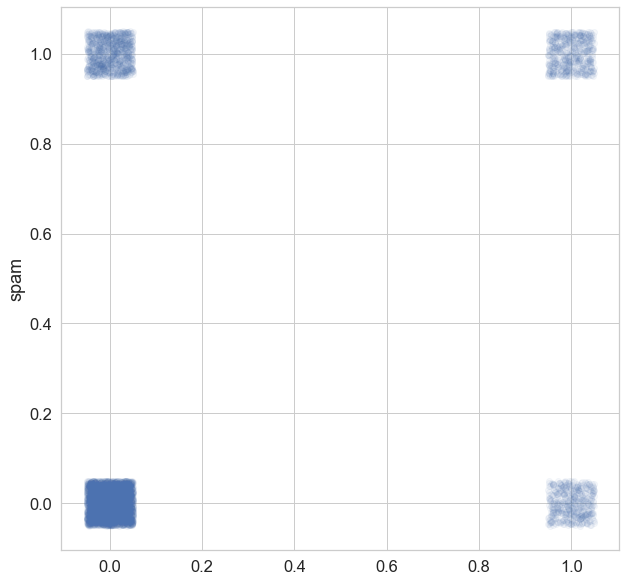

In [22]:
plt.figure(figsize=(10, 10))
sns.regplot(data=train, x=is_more_than_4100(train['email']), y='spam', fit_reg = False, y_jitter=0.05, x_jitter=0.05, scatter_kws = {'alpha' : 0.05});

In [23]:
def num_of_nums(emails):
    '''
    Args:
        emails (series): strings to search in 
    
    Returns:
        array the amount of numbers in an email with shape (n, 1) where n is the
        number of emails.
    '''
    size_for_each_email = []
    for email in emails:
        size = len(re.findall(r'(\d+)', email))
        size_for_each_email.append(size)
    size_for_each_email = np.array(size_for_each_email)
    return size_for_each_email
num_of_nums(['hello me nam is 8 and9', 'hi is 9 here'])

array([2, 1])

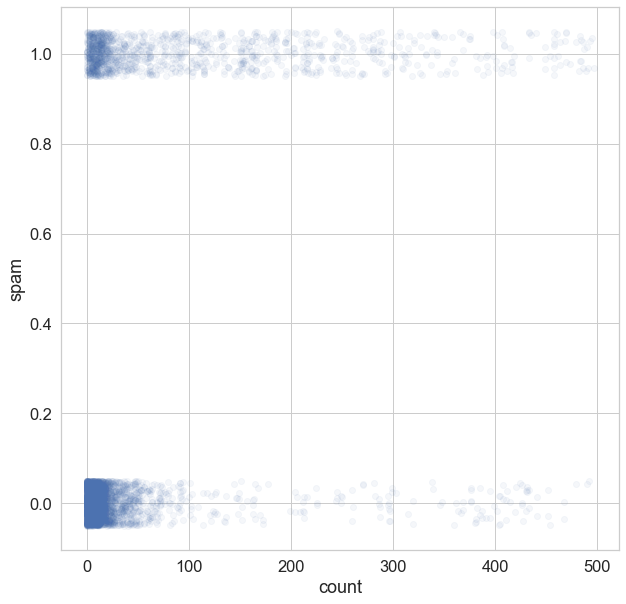

In [24]:
plt.figure(figsize=(10, 10))
num_of_digits = pd.DataFrame({"count": num_of_nums(train['email']), "spam": train['spam']})
sns.regplot(data=num_of_digits[num_of_digits['count']<500], x='count', y='spam', fit_reg = False, y_jitter=0.05, x_jitter=0.05, scatter_kws = {'alpha' : 0.05});


#### Lets make a function for single words

In [25]:
def find_percent(emails, word):
    '''
    Args:
        emails (series): strings to search in 
        word (string): string to search for in email
    
    Returns:
        array the amount of numbers in an email with shape (n, 1) where n is the
        number of emails.
    '''
    percent_count = []
    for email in emails:
        has_percent = email.count(word)
        percent_count.append(has_percent)
    percent_count = np.array(percent_count)
    return percent_count

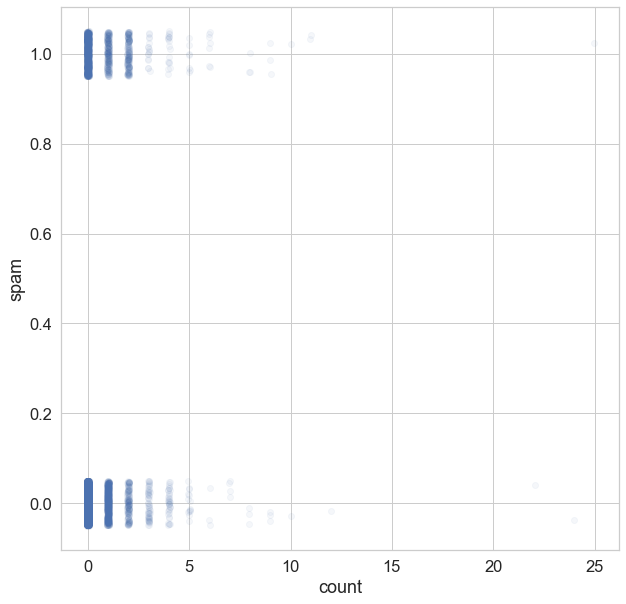

In [26]:
plt.figure(figsize=(10, 10))
my_chosen_word = 'want'
number_of_chosen_word = pd.DataFrame({"count": find_percent(train['email'], my_chosen_word), "spam": train['spam']})
sns.regplot(data=number_of_chosen_word[number_of_chosen_word['count']<100], x='count', y='spam', fit_reg = False, y_jitter=0.05, x_jitter=0.05, scatter_kws = {'alpha' : 0.05});


In [27]:
def has_word(emails, word):
    '''
    Args:
        emails (series): strings to search in 
        word (string): string to search for
    
    Returns:
        array of 1's and 0's describing if the word was found in the email. 
    '''
    size_for_each_email = []
    for email in emails:
        if word in email:
            size_for_each_email.append(1)
        else:
            size_for_each_email.append(0)
    return size_for_each_email
            

#### Lets try to create a matrix with all words (not repeated) used in all emails.

In [28]:
def find_all_words(emails):
    '''
    Args:
        emails (series): strings to search in 
    
    Returns:
        array of strings/words in all emails with shape (n, 1) where n is the
        number of unique words in all emails.
    '''
    all_words = []
    r="<\/[^>]*>"
    r2 = "<[^>]*>"
    r3 = "\s+"
    r4 = "\d+"
    r5 = "\w+"
    for email in emails:
        email_edit = re.sub(r, ' ', email)
        email_edit = re.sub(r2, ' ', email_edit)
        email_edit = re.sub(r4, ' ', email_edit)
        email_edit = re.sub(r3, ' ', email_edit)
        list_of_words = re.findall(r5, email_edit)
        all_words.extend(list_of_words)
    return sorted(set(all_words)) # Will give us a sorted list of unique words

In [29]:
print(find_all_words([first_ham,first_spam]))

['_', '_thanks', 'a', 'aldaily', 'and', 'are', 'arts', 'auctioned', 'bankruptcy', 'be', 'better', 'blog', 'boing', 'boingboing', 'by', 'com', 'come', 'company', 'daily', 'date', 'dense', 'discuss', 'done', 'due', 'endowed', 'enough', 'equipped', 'fall', 'folded', 'get', 'guaranteed', 'h', 'hammer', 'has', 'have', 'here', 'how', 'http', 'in', 'increase', 'is', 'it', 'its', 'jf', 'job', 'l', 'letters', 'link', 'man', 'methods', 'misha', 'more', 'net', 'not', 'of', 'off', 'or', 'our', 'parent', 'quicktopic', 'rather', 'receivers', 's', 'see', 'short', 'simply', 'size', 'supplied', 'tent', 'than', 'the', 'to', 'totally', 'up', 'url', 'will', 'with', 'wonderful', 'would', 'www', 'y', 'you', 'zlfterjnd']


#### All words used in all emails (spam and ham)

In [30]:
# Here we have 
english_words_file = open("/usr/share/dict/words", "r")
english_words = re.sub("[^\w]", " ",  english_words_file.read()).split()
english_words = set(english_words)
english_words_file.close()
    
def is_word(word):
    '''
    Args:
        word (string): word to check 
    
    Returns:
        True or False depending on whether the word is in the english dictionary
    '''
    return word.lower() in english_words

In [31]:
all_words = find_all_words(train['email'])
all_words = [word for word in all_words if len(word)>3 and len(word)<11 and not '_' in word]
all_words = [word for word in all_words if is_word(word)]
print(all_words[0:80])
print("Number of total english words:", len(all_words))

['abandon', 'abandoned', 'abatement', 'abbas', 'abbey', 'abdominal', 'abduction', 'aberrant', 'aberration', 'abhorrent', 'abide', 'ability', 'abject', 'able', 'ably', 'abnegate', 'abnormal', 'abnormally', 'aboard', 'abode', 'abolish', 'abolition', 'aboriginal', 'abort', 'aborted', 'abortive', 'abound', 'about', 'above', 'abreast', 'abridged', 'abroad', 'absconded', 'absence', 'absent', 'absinthe', 'absinthium', 'absolute', 'absolutely', 'absorb', 'absorbed', 'absorber', 'absorbing', 'absorption', 'abstract', 'abstracted', 'absurd', 'absurdity', 'absurdly', 'abundance', 'abundant', 'abundantly', 'abuse', 'abusive', 'abysmal', 'abyss', 'academic', 'academy', 'accelerate', 'accent', 'accentuate', 'accept', 'acceptable', 'acceptance', 'accepted', 'access', 'accessible', 'accession', 'accessory', 'accident', 'accidental', 'accidently', 'accolade', 'accompany', 'accomplish', 'accord', 'accordance', 'according', 'account', 'accountant']
Number of total english words: 12513


In [32]:
def new_matrix(emails, words):
    '''
    Args:
        emails (series): strings to search in 
        word (string): string to search for
    
    Returns:
        Array of 1's and 0's with shape (n, p) where n is the
        number of emails and p is the number of words.
    '''
    x_matrix_2 = []
    for word in words:
        column_ = has_word(emails, word)
        x_matrix_2.append(column_)
    return np.array(x_matrix_2).T

# Now Lets start with the Model Creation

#### Lets create a Function that gives us the matrix

In [94]:
import random
def create_matrix(emails, subjects):
    reply_list = is_reply(subjects)
    exclamation_count = find_exclamations(emails)
    htmls_count = find_html_tags(emails)
    actual_html_count = find_html_tags_count(emails)
    more_than_4100_list = is_more_than_4100(emails)
    less_than_500_list = is_less_than_500(emails)
    guarantee_count = find_percent(emails, 'guarantee')
    order_count = find_percent(emails, 'order')
    email_count = find_percent(emails, 'email')
    char_count = find_percent(emails, '?')
    dear_count = find_percent(emails, 'dear')
    greatings_count = find_percent(emails, 'date')
    copright = find_percent(emails, 'i')
    nums = num_of_nums(emails)
    #5500
    random.seed(42)
    words_appearances = new_matrix(emails, random.sample(all_words, 6000))
    
    perameters = words_appearances
    more_perams = [htmls_count, char_count, exclamation_count, reply_list, guarantee_count, dear_count, greatings_count, nums, order_count, actual_html_count]
    for perams in more_perams:  
        perameters = np.column_stack((perameters, perams))
#     perameters = perameters.DataFrame({'HTML Tag Amount': htmls_count, '2nd':char_count, '3rd':exclamation_count, '4th':reply_list, '5th':guarantee_count, '6th':dear_count, '7th':greatings_count, '8th':nums, '9th':order_count, '10th': actual_html_count})
#     return parameters.to_numpy()
    return perameters

#### Lets now create the Data Frame and X matrix and take a look at Training Accuracy

In [95]:
#Will tell us the precision, recall, and False-alarm rate 
def further_model_descriptions(y_pred, Y_answer):
    tp2 = np.sum((y_pred == 1) & (Y_answer == 1))
    tn2 = np.sum((y_pred == 0) & (Y_answer == 0))
    fp2 = np.sum((y_pred == 1) & (Y_answer == 0))
    fn2 = np.sum((y_pred == 0) & (Y_answer == 1))

    second_model_precision = tp2/(tp2+fp2)
    second_model_recall = tp2/(tp2+fn2)
    second_model_far = fp2/(fp2+tn2)

    print("Out of all the emails flagged as spam, how many are actually spam: ", second_model_precision)
    print("Out of all the spam emails, how many were actually flagged as spam: ", second_model_recall)
    print("Out of all the ham emails, how many were incorrectly flagged as spam : ", second_model_far)

In [96]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
X_matrix = create_matrix(train['email'], train['subject'])
Y_answers = np.array(train['spam'])
# X_matrix.shape, Y_answers.shape

my_model = LogisticRegression(penalty='l2', solver='newton-cg')

X_train, X_val, y_train, y_val = train_test_split(X_matrix, Y_answers, test_size=0.2, random_state = 42)

In [97]:
my_model.fit(X_train, y_train)

my_training_accuracy = my_model.score(X_train, y_train)
print("My Training Accuracy: ", my_training_accuracy)

My Training Accuracy:  0.9988824318283416


#### Let's now look at the precision, recall, and False-alarm rate of our improved model

In [98]:
training_predictions = my_model.predict(X_train)

further_model_descriptions(training_predictions, y_train)

Out of all the emails flagged as spam, how many are actually spam:  1.0
Out of all the spam emails, how many were actually flagged as spam:  0.9956634865568084
Out of all the ham emails, how many were incorrectly flagged as spam :  0.0


#### As seen our model improved much more in all aspects!
#### Now Lets test the validation data

In [99]:
my_validation_accuracy = my_model.score(X_val, y_val)
further_model_descriptions(my_model.predict(X_val), y_val)
print("My Test Accuracy: ", my_validation_accuracy)

Out of all the emails flagged as spam, how many are actually spam:  0.978494623655914
Out of all the spam emails, how many were actually flagged as spam:  0.978494623655914
Out of all the ham emails, how many were incorrectly flagged as spam :  0.007142857142857143
My Test Accuracy:  0.9892761394101877


#### Lets Take a look at Test Accuracy

In [100]:
Test_matrix = create_matrix(test['email'], test['subject'])
Test_answers = np.array(test['spam'])

my_test_accuracy = my_model.score(Test_matrix, Test_answers)
further_model_descriptions(my_model.predict(Test_matrix), Test_answers)
print("My Test Accuracy: ", my_test_accuracy)

Out of all the emails flagged as spam, how many are actually spam:  0.9742489270386266
Out of all the spam emails, how many were actually flagged as spam:  0.961864406779661
Out of all the ham emails, how many were incorrectly flagged as spam :  0.008793356130923302
My Test Accuracy:  0.9836660617059891


# Some EDA Performed Previously

,Body,Html,Tags,Ending Tags
Body,1.000000,0.518467,0.728277,0.728277
Html,0.518467,1.000000,0.625947,0.625947
Tags,0.728277,0.625947,1.000000,1.000000
Ending Tags,0.728277,0.625947,1.000000,1.000000


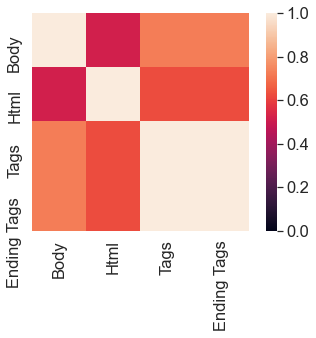

In [39]:
def find_words(emails, word):
    word_count = []
    for email in emails:
        has_percent = word in email
        if (has_percent):
            word_count.append(1)
        else:
            word_count.append(0)
    word_count = np.array(word_count)
    return word_count

emails = train['email']
body_count = find_words(emails, 'body')
html_count = find_words(emails, 'html')
tag_count = find_words(emails, '</')
html_tags_count = find_html_tags(emails)
plot2 = pd.DataFrame({'Body':body_count, 'Html':html_count, 'Tags':html_tags_count, 'Ending Tags':tag_count})
plot2.head(50)

corr=plot2.corr()

plot=sns.heatmap(corr, vmin=0, vmax=1, square=True);

corr

Above I made a heatmap for the correlations between whether or not the strings: 'body', 'html', '</' and the regex expression for tags appeared in emails. As we can see the lighter the color, the higher the correlation. As seen neither of the pairing have a correlation less that 0.5. Meaning these words are highly correlated and co-occur relatively frequently.